# Bank Beta

Saya memiliki data nasabah `Bank Beta`, dan tujuan saya adalah memperkirakan apakah mereka nasabah bank akan segera meninggalkan bank atau tidak. Saya juga memiliki data riwayat pemutusan kontrak dengan nasab. Untuk memprediksi perilakunya, saya akan mencoba berbagai model pengklasifikasi mechine learning yaitu; `Logistic Regression, Decision Tree, Random Forest`. Saya akan mencari baris duplikat dan mengisi nilai yang hilang. Lalu membagi data menjadi kumpulan `fitur` dan `target`. Untuk melatih model Logistic Regerssion, saya harus mengkodekan fitur kategorikal dan menstandardisasi fitur numerik; untuk model tree/forest , saya akan menggunakan pengkodean ordinal dan standarisasi numerik. Saya akan membagi kedua kerangka data menjadi set pelatihan, validasi, dan pengujian.

Saya akan memeriksa keseimbangan kelas dalam target, dan mencoba membangun model tanpa menyeimbangkan kelas, dengan memperhatikan skor F1 dan akurasi. Saat saya melatih model, saya akan mengoptimalkan skor F1 setinggi mungkin, dengan akurasi sebagai catatan tambahan.

Kemudian saya akan menggunakan fungsi `downsampling` dan `upsampling` untuk menyeimbangkan jumlah observasi target positif dan negatif (kelas), melatih dan memvalidasi model dengan kumpulan data yang telah diproses sepenuhnya, dan memilih model dengan skor F1 tertinggi. Pada akhirnya saya akan menguji skor akhir F1 model menggunakan set pengujian dan menemukan skor AUC-ROC. Persyaratan utama agar model berhasil adalah skor F1 yang diuji `minimal 0,59`. Saya juga akan melakukan `sanity check` pada keakuratannya dan mengharuskan model yang diuji akhir melampaui skor akurasi yang diperoleh secara kebetulan, dan AUC-ROC harus `lebih dari 0,50`.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt 

# from sklearnex import patch_sklearn 
# patch_sklearn()

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score, roc_curve, precision_recall_curve
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.utils import shuffle

from joblib import dump

## Preprocessing

In [2]:
try:
    churn_data= pd.read_csv('churn.csv')
except:
    churn_data = pd.read_csv('/datasets/Churn.csv')

In [3]:
churn_data.info ()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


Terlihat dari info diatas bahwasannya pada data untuk kolom `Tenure` Terdapat nilai yang hilang

<AxesSubplot:>

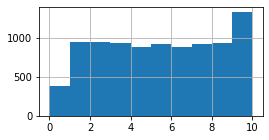

In [4]:
#memeriksa normalitas

churn_data.Tenure.hist(figsize=(4,2)) 

Distribusinya seragam, tidak normal. Meskipun mean dan median sepertinya hampir sama. Mari kita gunakan median untuk mengisi nilai.

In [5]:
churn_data.Tenure = churn_data.Tenure.fillna(churn_data.Tenure.median()).astype('int')

In [6]:
churn_data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [7]:
churn_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


In [8]:
churn_data.duplicated().sum()

0

`churn_data` tidak memiliki duplikat data

Selanjutkan memproses dataframe menggunakan pengkodean `one-hot` saat kita menguji model Logistic Regerssion, dan secara terpisah menggunakan pengkodean ordinal saat kita menguji model Decision Tree dan pengklasifikasi Random Forest. Kategori  `geography` dan `gender`, keduanya bersifat nominal, jadi kita tidak perlu khawatir untuk memberikan perintah pada fitur tersebut.

In [9]:
features = churn_data.drop(['RowNumber', 'CustomerId', 'Surname', 'Exited'], axis=1) #Hilangkan fitur (pengidentifikasi) yang tidak membantu bersama dengan targetnya
target = churn_data.Exited

##  Prepare Logistic Regression Data

In [10]:
features_ohe = pd.get_dummies(features, drop_first=True) # Membuat kerangka data berkode one-hot untuk regresi logistik Regression

Sekarang kita telah membahas variabel kategori, saya ingin membakukan variabel numerik. Kita dapat menggunakan kelas scaler standar untuk ini. Namun, kita perlu membagi data menjadi set pelatihan, validasi, dan pengujian sebelum saya membakukan data, untuk memastikan kelas menggunakan mean/varians yang paling tepat untuk penghitungannya.

Saya ingin 60% data digunakan untuk pelatihan, dan 20% untuk setiap set validasi dan pengujian. Pertama-tama kami akan membagi fitur dan kumpulan data target menjadi kumpulan pelatihan dan kumpulan pengujian, dengan rasio 80/20. Kemudian, kita dapat membagi lebih lanjut set pelatihan baru ini menjadi set pelatihan akhir dan set validasi. Dalam hal ini, set validasi harus berasal dari 25% set pelatihan untuk menghasilkan rasio 60/20/20. Hal ini karena 25% dari 80 sama dengan 20.

In [11]:
x_train, features_test_ohe, y_train, target_test = train_test_split(
    features_ohe, target, test_size=0.2, random_state=123)

features_train_ohe, features_valid_ohe, target_train, target_valid = train_test_split(
    x_train, y_train, test_size=0.25, random_state=123)

In [12]:
numeric = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']

scaler = StandardScaler()
scaler.fit(features_train_ohe[numeric])

features_train_ohe = features_train_ohe.copy()
features_valid_ohe = features_valid_ohe.copy()
features_test_ohe = features_test_ohe.copy()

features_train_ohe.loc[:, numeric] = scaler.transform(features_train_ohe[numeric])
features_valid_ohe.loc[:, numeric] = scaler.transform(features_valid_ohe[numeric])
features_test_ohe.loc[:, numeric] = scaler.transform(features_test_ohe[numeric])



In [13]:
features_train_ohe.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
8189,0.652468,-1.698690,1.096509,-1.213083,0.781092,1,0,-0.535390,0,0,1
8845,0.796864,0.002583,-1.450269,0.886952,-0.920634,1,1,1.637287,1,0,0
1165,0.621526,0.947735,0.005033,1.258423,0.781092,0,0,1.681465,1,0,0
1742,-0.698668,1.420312,-1.450269,0.022130,-0.920634,0,0,0.672609,1,0,0
1139,0.776236,1.703857,-1.450269,0.538309,-0.920634,0,1,-1.715362,0,1,0


Tabelnya terlihat sebagaimana mestinya. Fitur kategorikal nominal telah dipecah menjadi fitur biner, dan fitur numerik telah diskalakan.

## Prepare Decision Tree / Random Forest Data

In [14]:
encoder = OrdinalEncoder()
features_ordinal = pd.DataFrame(encoder.fit_transform(features), columns=features.columns) #Membuat encoded label dataframe untuk decision tree 
features_ordinal.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,228.0,0.0,0.0,24.0,2.0,0.0,0.0,1.0,1.0,5068.0
1,217.0,2.0,0.0,23.0,1.0,743.0,0.0,0.0,1.0,5639.0
2,111.0,0.0,0.0,24.0,8.0,5793.0,2.0,1.0,0.0,5707.0
3,308.0,0.0,0.0,21.0,1.0,0.0,1.0,0.0,0.0,4704.0
4,459.0,2.0,0.0,25.0,2.0,3696.0,0.0,1.0,1.0,3925.0


In [15]:
x_train, features_test_ord, y_train, target_test = train_test_split(
    features_ordinal, target, test_size=0.2, random_state=123)

features_train_ord, features_valid_ord, target_train, target_valid = train_test_split(
    x_train, y_train, test_size=0.25, random_state=123)

In [16]:
numeric = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']

scaler = StandardScaler()
scaler.fit(features_train_ohe[numeric])

features_train_ord = features_train_ohe.copy()
features_valid_ord = features_valid_ohe.copy()
features_test_ord = features_test_ohe.copy()

features_train_ord.loc[:, numeric] = scaler.transform(features_train_ohe[numeric])
features_valid_ord.loc[:, numeric] = scaler.transform(features_valid_ohe[numeric])
features_test_ord.loc[:, numeric] = scaler.transform(features_test_ohe[numeric])

In [17]:
features_train_ord.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
8189,0.652468,-1.698690,1.096509,-1.213083,0.781092,1,0,-0.535390,0,0,1
8845,0.796864,0.002583,-1.450269,0.886952,-0.920634,1,1,1.637287,1,0,0
1165,0.621526,0.947735,0.005033,1.258423,0.781092,0,0,1.681465,1,0,0
1742,-0.698668,1.420312,-1.450269,0.022130,-0.920634,0,0,0.672609,1,0,0
1139,0.776236,1.703857,-1.450269,0.538309,-0.920634,0,1,-1.715362,0,1,0


Tabelnya terlihat sebagaimana mestinya. Fitur kategorikal nominal telah diubah menjadi kode angka, dan fitur numerik telah distandarisasi.

## Train Models Without Balancing Classes

Kita bisa melihat Seri target untuk melihat keseimbangan antara kelas positif dan negatif.

In [18]:
target_classes = target.value_counts()
print(target_classes)

0    7963
1    2037
Name: Exited, dtype: int64


In [19]:
class_ratio = target_classes[0]/target_classes.sum() #Menampilkan sanity check
print(class_ratio, 'dari target observasinya negatif.')

0.7963 dari target observasinya negatif.


Tampaknya terdapat lebih banyak observasi sasaran negatif dibandingkan observasi positif. Saat ini mencoba menyeimbangkannya nanti, namun untuk saat ini kami akan melatih beberapa model. Ini akan membantu kita melihat pentingnya keseimbangan kelas. Kami akan mengevaluasi model berdasarkan akurasi (setidaknya harus 80% akurat, berdasarkan pemeriksaan kewarasan), dan pada akhirnya berdasarkan skor F1 tertinggi.

Model regresi logistik berkinerja lebih buruk dalam hal skor F1 daripada yang saya harapkan. Skor F1 yang lebih rendah untuk set validasi mungkin menunjukkan adanya overfitting. Akurasinya tepat di atas ambang batas 0,80.

###  Decision Tree Model

In [20]:
best_depth = 0
model_accuracy = 0
best_f1_score = 0
model_tree = None

for depth in range(1,11):
    model = DecisionTreeClassifier(max_depth=depth, random_state = 123) # create instance of class
    model.fit(features_train_ord, target_train) # Fit model dengan training data
    pred_valid = model.predict(features_valid_ord)
    
    f1_score_var = f1_score(target_valid, pred_valid) # Menghitung score f1
    accuracy = accuracy_score(target_valid, pred_valid)

    #Dokumentasikan hyperparameter dengan performa tertinggi, beserta akurasinya yang sesuai.
    if f1_score_var > best_f1_score: 
        best_f1_score = f1_score_var
        model_accuracy = accuracy
        best_depth = depth
        model_tree = model
        
print(f'Best F1 score: {best_f1_score} diperoleh dengan kedalaman maksimum {best_depth}.') 
print(f'Model accuracy: {model_accuracy}') 

Best F1 score: 0.5677233429394812 diperoleh dengan kedalaman maksimum 5.
Model accuracy: 0.85


Dengan menggunakan `Decision Tree` skor f1 sedikit di bawah persyaratan, namun keakuratannya di atas persyaratan. Mari kita coba hutan acak.

###  Random Forest Model

In [21]:
best_f1_score = 0
model_accuracy = 0
best_est = 0
best_depth = 0
model_forest = None

for est in range (10, 101, 10):
    for depth in range (1, 11):
        model = RandomForestClassifier(
            max_features=1.0,
            n_estimators=est, max_depth=depth, random_state=123)
        model.fit(features_train_ord, target_train)
        pred_valid = model.predict(features_valid_ord)
        
        f1_score_var = f1_score(target_valid, pred_valid) #Menghitung f1 score
        accuracy = accuracy_score(target_valid, pred_valid)
        
        if f1_score_var > best_f1_score: 
            best_f1_score = f1_score_var
            model_accuracy = accuracy
            best_depth = depth
            best_est = est
            model_tree = model
            
print(f"Best F1 score: {best_f1_score} obtained using {best_est} trees with\
 max_depth {best_depth}.")
print(f'Model accuracy: {model_accuracy}')

Best F1 score: 0.5757575757575758 obtained using 30 trees with max_depth 6.
Model accuracy: 0.86


Model `Random Forest` berkinerja sedikit lebih baik dalam hal skor F1 dibandingkan `Single Decision Tree`. Namun masih belum mencapai persyaratan 0,59. Akurasinya masih di atas cutoff 0,80. Mari kita coba `Logistics Regression` menggunakan fitur OHE.

Model dengan skor F1 teratas saat ini merupakan pengklasifikasi hutan acak dengan skor F1 sebesar 0,56, yang hampir memenuhi persyaratan kami sebesar 0,59. Menyeimbangkan kelas seharusnya dapat meningkatkan skor F1 untuk model ini secara memadai.

## Balance Classes and Retrain Models

In [22]:
def upsample(features, target, repeat): # Upsamples the positive class
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)

    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=54321)

    return features_upsampled, target_upsampled

In [23]:
def downsample(features, target, fraction): # Downsamples the negative class
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=54321)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=54321)] + [target_ones])

    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=54321)

    return features_downsampled, target_downsampled

### Logistics Regression Model

Mari kita seimbangkan kelas dengan melakukan sedikit downsampling dan upsampling, pertama-tama fokus pada kumpulan data regresi logistik. Tujuan saya menggunakan model ini adalah agar kelas-kelasnya seimbang.

In [24]:
features_train_ohe_downsampled, target_train_downsampled = downsample(features_train_ohe, target_train, 0.5)
features_train_ohe_balanced, target_train_balanced = upsample(features_train_ohe_downsampled, target_train_downsampled, 2)

print(features_train_ohe_balanced.shape)
print(target_train_balanced.shape)
print(target_train_balanced.value_counts())

(4804, 11)
(4804,)
1    2406
0    2398
Name: Exited, dtype: int64


Kelas-kelas telah diseimbangkan secara merata melalui kombinasi `downsampling` dan `upsampling`. Kedua set tersebut memiliki panjang yang sama.

In [25]:
model = LogisticRegression(solver='liblinear', random_state=123) # Menggunakan liblinear untuk dataset ukuran kecil
model.fit(features_train_ohe_balanced, target_train_balanced)

pred_train = model.predict(features_train_ohe)
f1_score_train = f1_score(target_train, pred_train)
accuracy_train = accuracy_score(target_train, pred_train)

print('F1 score for training set:', f1_score_train)
print('Accuracy for training set:', accuracy_train)
print()

pred_valid = model.predict(features_valid_ohe)
f1_score_valid = f1_score(target_valid, pred_valid)
accuracy_valid = accuracy_score(target_valid, pred_valid)

print('F1 score for validation set:', f1_score_valid)
print('Accuracy for validation set:', accuracy_valid)

F1 score for training set: 0.4860253015592822
Accuracy for training set: 0.7088333333333333

F1 score for validation set: 0.49871904355251917
Accuracy for validation set: 0.7065


Skor validasi F1 sedikit lebih tinggi dibandingkan ketika kelas tidak seimbang, meskipun masih sedikit di bawah persyaratan. Skor akurasinya pun menurun.

###  Decision Tree Model

In [26]:
features_train_ord_downsampled, target_train_downsampled = downsample(features_train_ord, target_train, 0.5)
features_train_ord_balanced, target_train_balanced = upsample(features_train_ord_downsampled, target_train_downsampled, 2)

print(features_train_ord_balanced.shape)
print(target_train_balanced.shape)
print(target_train_balanced.value_counts())

(4804, 11)
(4804,)
1    2406
0    2398
Name: Exited, dtype: int64


In [27]:
best_depth = 0
model_accuracy = 0
best_f1_score = 0
model_tree = None

for depth in range(1,11):
    model = DecisionTreeClassifier(max_depth=depth, random_state = 123)
    model.fit(features_train_ord_balanced, target_train_balanced) # Fit model dengan training data
    pred_valid = model.predict(features_valid_ord)
    
    f1_score_var = f1_score(target_valid, pred_valid) # Menghitung score f1
    accuracy = accuracy_score(target_valid, pred_valid)

    # Dokumentasikan hyperparameter dengan performa tertinggi, beserta akurasinya yang sesuai
    if f1_score_var > best_f1_score: 
        best_f1_score = f1_score_var
        model_accuracy = accuracy
        best_depth = depth
        model_tree = model
        
print(f'Best F1 score: {best_f1_score} diperoleh dengan kedalaman maksimum {best_depth}.') 
print(f'Model accuracy: {model_accuracy}') 

Best F1 score: 0.5588235294117648 diperoleh dengan kedalaman maksimum 7.
Model accuracy: 0.775


Skor F1 sedikit lebih tinggi dibandingkan sebelum kelas penyeimbangan, namun masih belum memenuhi persyaratan.

###  Random Forest Model

Random Forest model adalah model dengan kinerja terbaik di bagian sebelumnya, saya ingin melakukan yang terbaik untuk mengoptimalkan model ini. Alih-alih membuat kelasnya sama, saya ingin menambahkan loop ke dalam pelatihan model saya yang akan meningkatkan dan menurunkan sampel data saya pada pengali dan pecahan yang berbeda, selain mengulang jumlah penduga dan kedalaman maksimal. Untuk menjaga performa model pada kecepatan yang wajar, saya akan menjaga jumlah penduga saya dalam kisaran yang lebih ketat daripada sebelumnya, yang diharapkan juga akan membantu menghindari overfitting.

In [28]:
best_f1_score = 0
model_accuracy = 0
best_est = 0
best_depth = 0
model_forest = None
best_x = 0
best_y = 0

for x in range(5, 11): # Melakukan loop melalui downsampling fractions 0.5 to 1
    for y in range(1, 4): # Melakukan loop melalui upsample multipliers 1 to 3 (see upsample function call below)
        for est in range (20, 51, 10):
            for depth in range (1, 11):
                
                features_train_ord_downsampled, target_train_downsampled = downsample(features_train_ord, target_train, x/10)
                features_train_ord_balanced, target_train_balanced = upsample(features_train_ord_downsampled, target_train_downsampled, y)
                
                model = RandomForestClassifier(
                    max_features=1.0,
                    n_estimators=est, max_depth=depth, random_state=123)
                model.fit(features_train_ord_balanced, target_train_balanced)
                pred_valid = model.predict(features_valid_ord)

                f1_score_var = f1_score(target_valid, pred_valid) # Menghitung score f1
                accuracy = accuracy_score(target_valid, pred_valid)

                if f1_score_var > best_f1_score: 
                    best_f1_score = f1_score_var
                    model_accuracy = accuracy
                    best_depth = depth
                    best_est = est
                    model_forest = model  
                    best_x = x
                    best_y = y
            
print(f"Best F1 score: {best_f1_score} obtained using {best_est} trees with\
 max_depth {best_depth}.")
print(f'Ideal class balance achieved using downsampling fraction {x/10} and upsampling multiplier {y}.')
print(f'Model accuracy: {model_accuracy}')

Best F1 score: 0.6192170818505338 obtained using 20 trees with max_depth 7.
Ideal class balance achieved using downsampling fraction 1.0 and upsampling multiplier 3.
Model accuracy: 0.8395


Skor F1 yang diukur dari set validasi adalah 0,61, yang berada di atas persyaratan sebesar 0,59 Skor ini dihasilkan dari zero downsampling dan 3x upsampling. Mungkin menghapus data pelatihan tidak selalu ideal. Hyperparameter: 30 pohon, kedalaman maksimal 9. Dengan nol downsampling dan 3x upsampling.

In [29]:
features_train_ord_downsampled, target_train_downsampled = downsample(features_train_ord, target_train, 1)
features_train_ord_balanced, target_train_balanced = upsample(features_train_ord_downsampled, target_train_downsampled, 3)

model_forest = RandomForestClassifier(
    max_features=1.0,
    n_estimators=30, max_depth=9, random_state=123)
model_forest.fit(features_train_ord_balanced, target_train_balanced)
pred_valid = model_forest.predict(features_valid_ord)

f1_score_var = f1_score(target_valid, pred_valid)  # Menghitung score f1
accuracy = accuracy_score(target_valid, pred_valid)

print(f"Best F1 score: {f1_score_var} obtained using 30 trees with max_depth 9.")
print(f'Ideal class balance achieved using downsampling fraction 1.0 and upsampling multiplier 3.')
print(f'Model accuracy: {accuracy}')


Best F1 score: 0.5890410958904109 obtained using 30 trees with max_depth 9.
Ideal class balance achieved using downsampling fraction 1.0 and upsampling multiplier 3.
Model accuracy: 0.82


<div class="alert alert-success">
<b>Chamdani's comment v.1</b> <a class="tocSkip"></a>

Hebat, Kerja bagus!

</div>

## Test Model 

Mari kita uji model dengan performa tertinggi, `Random Forest` model.


In [30]:
pred_test = model_forest.predict(features_test_ord)
f1_score_test = f1_score(target_test, pred_test)
accuracy_test = accuracy_score(target_test, pred_test)

print('F1 score for test set:', f1_score_test)
print('Accuracy for test set:', accuracy_test)

F1 score for test set: 0.6361607142857142
Accuracy for test set: 0.837


Skor F1 jauh di atas persyaratan yang ditentukan yaitu 0,59 Dan akurasinya juga berada di atas persyaratan yang telah ditentukan yaitu 0,80, yang menunjukkan bahwa model kami memiliki performa lebih baik daripada menebak semua angka nol. Selanjutnya Mari kita periksa skor AUC-ROC

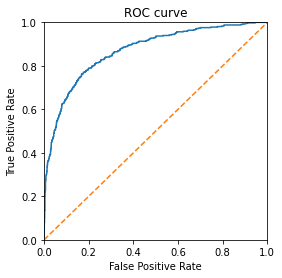

AUC-ROC score: 0.8692933640367709


In [31]:
probabilities_test = model_forest.predict_proba(features_test_ord)
probabilities_one_test = probabilities_test[:, 1]

fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)

plt.figure(figsize=(4,4))
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0,1])
plt.ylim([0,1])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')

plt.show()

auc_roc = roc_auc_score(target_test, probabilities_one_test)
print(f"AUC-ROC score: {auc_roc}")

Skor AUC-ROC jauh di atas 0,5 dan kurvanya terlihat sangat bagus. Model ini memenuhi semua persyaratan.

In [32]:
dump(model_forest, 'BetaBankChurnPredictor.joblib')

['BetaBankChurnPredictor.joblib']

## Kesimpulan

Tujuan dari project ini adalah membangun model klasifikasi yang dapat memprediksi apakah nasabah Bank Beta akan tetap berada di bank Beta atau tidak dalam waktu dekat. Untuk mencapai hal ini, saya memproses data dengan membaginya menjadi `features/target`, membaginya menjadi set `training/validation/testing test`, dan menstandarkan fitur dengan cara yang sesuai dengan model yang di latih - pengkodean `one-hot` untuk Logistic Regression, dan pengkodean label untuk Decisision Tree dan juga Random Forest. Lalu menyeimbangkan kelas dan menemukan bahwa model Random Forest (dengan 30 pohon, kedalaman maksimal 9, nol downsampling, dan 3x upsampling) memiliki performa terbaik dalam hal skor F1. Persyaratan untuk skor F1 adalah 0,59, dan model ini memiliki skor F1 0,64 saat dilatih dengan untuk scikit-learn, dan skor F1 0,63 tanpa ekstensi ini, serta skor akurasi dan AUC-ROC yang lolos pemeriksaan sanity check. Saya menyimpan model sebagai file .joblib ke mesin learning untuk diamankan. Secara pribadi, saya mencari tahu kapan harus menggunakan enkode `one-hot` vs `encode lable`, dan memikirkan cara menstandardisasi fitur numerik. Menyeimbangkan kelas ternyata cukup rumit dari yang diperkirakan, namun pada akhirnya saya menyempurnakan skor F1.